In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/hdaniel/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/hdaniel/.local/lib/python3.8/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


In [2]:
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

stations = ['SGP', 'EGB', 'AMA', 'SAO', 'HRW', 'VIE', 'BSL', 'WAL', 'POV', 'MLP', 'ABZ',
            'ABZ', 'NEU', 'VHL', 'KCE', 'ASP', 'KPZ', 'PRL', 'HYY', 'HEL', 'VAR', 'BOT',
            'MAR', 'AMM', 'HAD', 'UAE', 'DEL', 'MUK', 'ZOT', 'BEI', 'NAN']

# filter
data = data[data.station.isin(stations)]
data = data[data.n100 >= 1]

aerosols = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11']

gases = ['co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2']

met = ['d2m', 't2m', 'blh', 'rh', 'wind_speed', 'crwc']
        
loc = ['latitude', 'longitude']

log_transform = ['n100'] + aerosols + gases + ['crwc']

# log-transforming the selected variables, setting negative values to the minimum observed positive value
for v in log_transform:
    data[v] = np.log(data[v].where(data[v] > 0, data[v][data[v] > 0].min()))    
    
data.head()

,id,station,date,latitude,longitude,n100,aermr01,aermr02,aermr03,aermr04,...,nh3,no,no2,so2,d2m,t2m,crwc,blh,rh,wind_speed
0,ABZ-2012-01-26 18:00:00,ABZ,2012-01-26 18:00:00,50.57,12.99,8.004610,-25.205400,-20.758221,-23.644620,-32.349837,...,-21.067484,-20.375236,-17.606319,-19.048942,265.94745,268.02210,-23.343861,341.34552,85.351851,2.343428
1,ABZ-2012-01-26 21:00:00,ABZ,2012-01-26 21:00:00,50.57,12.99,7.930467,-25.128177,-20.680886,-23.922713,-33.939763,...,-20.798013,-19.560968,-17.517805,-18.690249,264.51917,266.25134,-23.343861,256.22314,87.455067,2.290729
2,ABZ-2012-01-27 00:00:00,ABZ,2012-01-27 00:00:00,50.57,12.99,7.648740,-25.586803,-21.139579,-24.793668,-30.044488,...,-20.315620,-18.490878,-17.415018,-18.248112,264.04578,265.29468,-23.343861,172.99615,90.734149,1.933842
3,ABZ-2012-01-27 03:00:00,ABZ,2012-01-27 03:00:00,50.57,12.99,7.493512,-26.083640,-21.636795,-25.519402,-28.561505,...,-20.260121,-17.796891,-17.333992,-18.250056,263.76500,265.05933,-23.343861,147.33954,90.393698,1.588926
4,ABZ-2012-01-27 06:00:00,ABZ,2012-01-27 06:00:00,50.57,12.99,7.599552,-26.317107,-21.870332,-26.070951,-27.517164,...,-20.694717,-17.289473,-17.435466,-18.717292,264.02032,265.33960,-23.343861,112.06348,90.239081,1.724053


In [3]:
data = data.head(2000)

In [4]:
# calculate time difference between consecutive rows
time_diff = data.groupby('station')['date'].diff()

# find rows where time difference is greater than 3 hours
gap_rows = time_diff > pd.Timedelta('3 hours')

# filter for rows where time difference is greater than 3 hours and convert to hours
gap_lengths = (time_diff[gap_rows]) / pd.Timedelta(hours=1)

# create a new segment every time a gap is detected
segment_ids = gap_rows.cumsum()

# create group_ids column by concatenating station name and segment_ids
data['group_ids'] = data['station'] + '_segment_' + segment_ids.astype(str)

# calculate the length of each segment
segment_lengths = data.groupby(['group_ids']).size() * 3

# group by group_ids, and assign a unique index to each row within each group
data['time_idx'] = data.groupby(['group_ids']).cumcount()

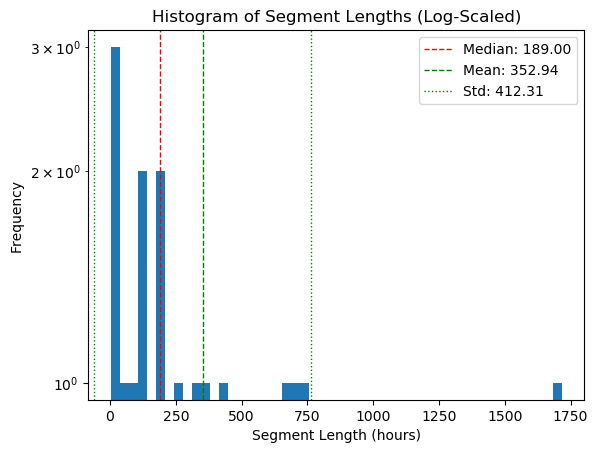

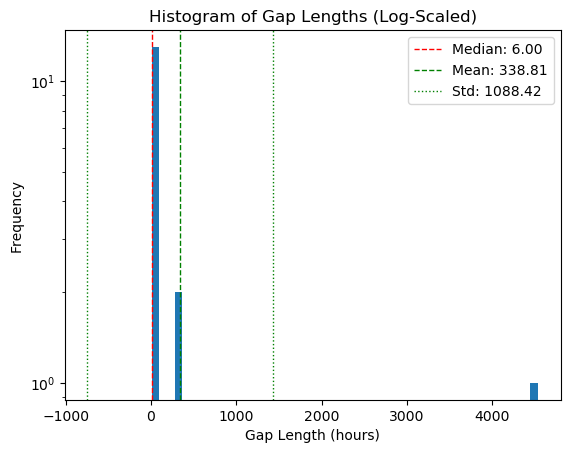

In [5]:
# calculate median, mean, and std for segment lengths
segment_median = np.median(segment_lengths)
segment_mean = np.mean(segment_lengths)
segment_std = np.std(segment_lengths)

# create histogram of segment lengths with median, mean, and std plotted
plt.hist(segment_lengths, bins=50, log=True)
plt.xlabel('Segment Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Segment Lengths (Log-Scaled)')
plt.axvline(segment_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean + segment_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(segment_mean - segment_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(segment_median), 'Mean: {:.2f}'.format(segment_mean), 'Std: {:.2f}'.format(segment_std)])
plt.show()

# calculate median, mean, and std for gap lengths
gap_median = np.median(gap_lengths)
gap_mean = np.mean(gap_lengths)
gap_std = np.std(gap_lengths)

# create histogram of gap lengths with median, mean, and std plotted
plt.hist(gap_lengths, bins=50, log=True)
plt.xlabel('Gap Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Gap Lengths (Log-Scaled)')
plt.axvline(gap_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean + gap_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(gap_mean - gap_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(gap_median), 'Mean: {:.2f}'.format(gap_mean), 'Std: {:.2f}'.format(gap_std)])
plt.show()

In [6]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [7]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [8]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="n100",
    group_ids=["group_ids"],
    min_encoder_length=1,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["station"],
    static_reals=["latitude", "longitude"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"] + gases + met + aerosols,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["n100"],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    target_normalizer=None
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 1  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [9]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu", default_root_dir="/ssd-home/hdaniel/forecast-ccn"))
MAE()(baseline_predictions.output.flatten(), baseline_predictions.y)

No protocol specified


tensor(0.4442)

In [10]:
from lightning_utilities.core.imports import RequirementCache

print(RequirementCache("tensorboard"))
print(RequirementCache("tensorboardx"))

Requirement 'tensorboard' met
DistributionNotFound: The 'tensorboardx' distribution was not found and is required by the application. HINT: Try running `pip install -U 'tensorboardx'`


In [11]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    default_root_dir="/ssd-home/hdaniel/forecast-ccn",
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 27.3k


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.8912509381337452
Restoring states from the checkpoint path at /ssd-home/hdaniel/forecast-ccn/.lr_find_1637d9fe-e9ad-4691-b361-a75991627b1f.ckpt
Restored all states from the checkpoint at /ssd-home/hdaniel/forecast-ccn/.lr_find_1637d9fe-e9ad-4691-b361-a75991627b1f.ckpt


suggested learning rate: 0.8912509381337452


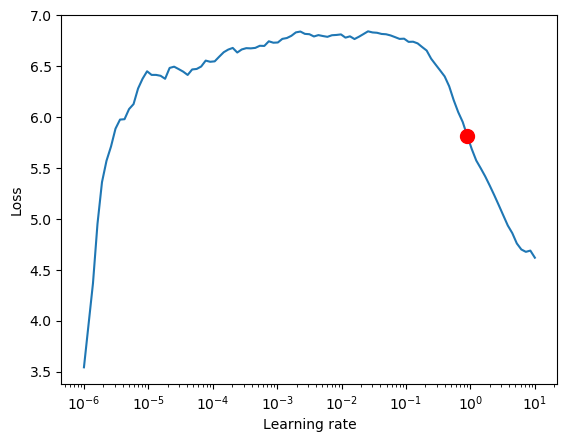

In [12]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## train the model

In [21]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = CSVLogger("/ssd-home/hdaniel/forecast-ccn")  # logging results to a tensorboard

logger = TensorBoardLogger("/ssd-home/hdaniel/forecast-ccn")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="gpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 54.6k


In [22]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 512   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.1 K 
5  |

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [23]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [24]:
predictions = best_model.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu", default_root_dir="/ssd-home/hdaniel/forecast-ccn"))
MAE()(predictions.output.flatten(), predictions.y)

tensor(0.3992)